Derived from

Keras blog: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [91]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


#  Set Keras backend

In [92]:
import os
os.environ["KERAS_BACKEND"] =  "tensorflow" # torch

import keras

print(f"Keras version {keras.__version__}, backend: {keras.backend.backend()}")



Keras version 3.8.0, backend: tensorflow


## List version of backend

In [93]:
if keras.backend.backend() ==  "tensorflow":
  import tensorflow as tf
  print(f"TensorFlow version {tf.__version__}")
elif keras.backend.backend() ==  "torch":
  import torch
  print(f"PyTorch version {torch.__version__}")


TensorFlow version 2.18.0


# List GPU's available

In [94]:
# prompt: depending on backend, list gpu devices available

if keras.backend.backend() == "tensorflow":
  gpu_available = tf.config.list_physical_devices('GPU')
  if gpu_available:
    print("GPU available with TensorFlow:")
    for gpu in gpu_available:
      print(f"  {gpu}")
  else:
    print("No GPU available with TensorFlow.")
elif keras.backend.backend() == "torch":
  if torch.cuda.is_available():
    print("GPU available with PyTorch:")
    device_names = [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]
    print(f"GPUs: {', '.join(device_names)}")
  else:
    print("No GPU available with PyTorch.")
else:
    print("Unknown Keras backend.")

GPU available with TensorFlow:
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Standard imports

In [95]:
import keras

import numpy as np
import os

import matplotlib.pyplot as plt
import IPython


from keras.utils import plot_model

import pdb

from pprint import pprint


# Keras imports

In [96]:
from keras.datasets import mnist, fashion_mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.utils import plot_model

Mount my Google Drive (have data stored there)

In [97]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Constants

In [98]:
# dimensions of our images.
img_width, img_height = 150, 150
image_size = 150
IMG_SHAPE = (image_size, image_size, 3)

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16


# Download the Cats and Dogs dataset

- The raw dataset comes from [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data) and is quite a large archive file.  We only need one file
  - train.zip

- A **subset** of the training data was created, and organized as described [here](https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975)
  - Only 1000 training examples, 400 validation examples, per animal type
  - The notebook "Dogs_and_Cats_reformat" will perform this reformatting
- The reformatted, subset of the dataset (much smaller) was placed in an archive, which is read in this step



Unzip the Cats and Dogs images into pwd (i.e., /content).  That is where the code is looking


In [99]:
import os
!pwd

data_dir="data"
os.makedirs(data_dir, exist_ok=True)


if not (os.path.isdir("train") and os.path.isdir("validation") ):
  %cd $data_dir
  !tar -zxvf '/content/gdrive/My Drive/data/cats_and_dogs/cats_v_dogs.tgz'
  %cd ..


/content
/content/data
./
./validation/
./validation/dogs/
./validation/dogs/dog.1302.jpg
./validation/dogs/dog.1242.jpg
./validation/dogs/dog.1108.jpg
./validation/dogs/dog.1088.jpg
./validation/dogs/dog.1140.jpg
./validation/dogs/dog.1357.jpg
./validation/dogs/dog.1194.jpg
./validation/dogs/dog.1162.jpg
./validation/dogs/dog.1219.jpg
./validation/dogs/dog.1142.jpg
./validation/dogs/dog.1005.jpg
./validation/dogs/dog.1138.jpg
./validation/dogs/dog.1293.jpg
./validation/dogs/dog.1382.jpg
./validation/dogs/dog.1331.jpg
./validation/dogs/dog.1389.jpg
./validation/dogs/dog.1154.jpg
./validation/dogs/dog.1375.jpg
./validation/dogs/dog.1352.jpg
./validation/dogs/dog.1244.jpg
./validation/dogs/dog.1325.jpg
./validation/dogs/dog.1329.jpg
./validation/dogs/dog.1322.jpg
./validation/dogs/dog.1304.jpg
./validation/dogs/dog.1183.jpg
./validation/dogs/dog.1363.jpg
./validation/dogs/dog.1393.jpg
./validation/dogs/dog.1012.jpg
./validation/dogs/dog.1240.jpg
./validation/dogs/dog.1009.jpg
./validatio

The following is from [Blog script 1](https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)

## Examine the examples
- is the data balanced ?
  - equal number of examples in each of the two classes ?
- the fraction in the larger class should act as a *lower bound* on accuracy of a model trained on this data
  - i.e., a model that ignores the data and always predicts the class of the majority

In [100]:
# prompt: for each of the directories "train" and "validation": express the fraction of the total files in each directory (including subdirectories) that are in the "cats" and "dogs" subdirectories

def count_files_in_directory(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

def count_files_in_subdirectories(directory, subdirectories):
    count = 0
    for subdir in subdirectories:
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            count += count_files_in_directory(subdir_path)
    return count

train_cats_count = count_files_in_subdirectories(train_data_dir, ["cats"])
train_dogs_count = count_files_in_subdirectories(train_data_dir, ["dogs"])
validation_cats_count = count_files_in_subdirectories(validation_data_dir, ["cats"])
validation_dogs_count = count_files_in_subdirectories(validation_data_dir, ["dogs"])

train_total_count = count_files_in_directory(train_data_dir)
validation_total_count = count_files_in_directory(validation_data_dir)

if train_total_count > 0:
    train_cats_fraction = train_cats_count / train_total_count
    train_dogs_fraction = train_dogs_count / train_total_count
    print(f"'train' examples: {train_cats_fraction*100:.2f}% cats; {train_dogs_fraction*100:.2f}% dogs")
else:
    print("No files found in the 'train' directory.")


validation_cats_dogs_count = count_files_in_subdirectories(validation_data_dir, ["cats", "dogs"])
validation_total_count = count_files_in_directory(validation_data_dir)

if validation_total_count > 0:
  validation_cats_fraction = validation_cats_count / validation_total_count
  validation_dogs_fraction = validation_dogs_count / validation_total_count
  print(f"'validation' examples: {validation_cats_fraction*100:.2f}% cats; {validation_dogs_fraction*100:.2f}% dogs")
else:
    print("No files found in the 'validation' directory.")


'train' examples: 50.00% cats; 50.00% dogs
'validation' examples: 50.00% cats; 50.00% dogs


In [101]:
train_cats_dogs_count



2000

# Utility routines
Based on:  https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

## Input handling

Examples for this notebook
- an example is an image contained in a directory
  - the label of the example is the name of the directory in which it is located
    - i.e., `cats`, `dogs`

Keras can handle multiple types of inputs (examples) in a backend-agnostic manner
- Keras 3 handle multiple types of inputs in a *backend-agnostic* way
  - pandas DataFrames
  - numpy arrays
  - TensorFlow Datasets (TFDS)
  - PyTorch DataLoader objects

Datasets are
- an efficient way to handle examples that are large is via a Dataset
  - a way of streaming data, with operations/transformations executed on the fly

In this notebook: we create a TensorFlowDataset
- which will work as an input source for either the TensorFlow or PyTorch backends
- this is a convenience
  - efficient handling of large examples (images)
  - can take advantage of TensorFlow image utilities
    - data augmentation
      - create additional synthetic examples from actual examples
      - by applying transformations that preserve the label
        - e.g., shift, rotate, flip

Best practice
- When using PyTorch back-end
  - `import torch` before importing the TensorFlow image utilities


In [102]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Training utilities

### The following routine is the only one that uses TensorFlow
- regardless of backend
- only to create a TFDS and use the TensorFlow image utilities

In [103]:
import re
import IPython

def trainModel(model, train_data_dir, validation_data_dir, input_shape=IMG_SHAPE):
  img_height, img_width = input_shape[:2]

  batch_size = 16
  epochs = 50

  # this is the augmentation configuration we will use for training
  # compile the model with a SGD/momentum optimizer
  # and a very slow learning rate.
  model.compile(loss='binary_crossentropy',
                metrics=['acc'])

  # Create a TFDS for the examples (train/test)
  # Create additional training examples to make the model more robust
  # - flipping a real example
  # - twisting a real example
  # Only training examples are augmented, not validation or test examples
  train_datagen = ImageDataGenerator(
      rescale=1. / 255,
      shear_range=0.2, # Twist the rectangle into a parallelogram by fixing one axis and move the other
      zoom_range=0.2,  # Zoom in/out
      horizontal_flip=True
      )

  test_datagen = ImageDataGenerator(rescale=1. / 255)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='binary')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='binary')

  es_callback = EarlyStopping(monitor='val_loss', min_delta=.005, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

  callbacks = [ es_callback,
                    # ModelCheckpoint(filepath=modelName + ".ckpt", monitor='acc', save_best_only=True)
                ]
  # fine-tune the model
  history = model.fit(
      train_generator,
      # samples_per_epoch=nb_train_samples,
      steps_per_epoch=nb_train_samples // batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=nb_validation_samples // batch_size,
      callbacks=callbacks
      )


  return history

In [104]:
def plot_training(history):
  """
  Plot training and validation statistics
  - accuracy vs epoch number
  - loss     vs epoch number

  From https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/
  """

  # Accuracy
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  # Loss
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

## Create model utilities

In [105]:

def createFirstModel(input_shape=IMG_SHAPE):
  img_height, img_width = input_shape[:2]

  # Back-end specific placement of channel (feature) dimensions
  if keras.backend.image_data_format() == 'channels_first':
      input_shape = (3, img_width, img_height)
  else:
      input_shape = (img_width, img_height, 3)

  model = Sequential()
  model.add(Input(shape=input_shape) )
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  return model

def createTransferModel(base_model, last_base_layer_name, down_conv_features=32):
  model = Sequential()

  # Find the last layer
  layer_names = [ l.name for l in base_model.layers ]
  last_base_layer_idx = layer_names.index(last_base_layer_name)

  print("Last layer {ll:s} is index {i:d}".format(ll=last_base_layer_name, i=last_base_layer_idx))
  for i, layer in enumerate(base_model.layers[:last_base_layer_idx+1]):
    model.add(layer)
    layer.trainable=False

  # Add down sampling
  model.add( Conv2D(down_conv_features, kernel_size=(1, 1), activation='relu') )

  # Add head
  model.add(Flatten())
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))


  return model

def plotModel(model, modelName):
  plotFile = modelName + ".png"
  plot_model(model, plotFile, show_shapes=True)

  return plotFile

# Problem description
- Binary classification problem, with small quantity of training data

- Cats and Dogs dataset:
  - a *small* number of examples
  - two classes: Cats, Dogs

Plan
1. Create and train own model
1. Transfer Learning
  - use the prefix of a pre-trained model
  - add own suffix
  

In [106]:
DOCSTRING = '''
This script goes along the blog post
"Building powerful image classification models using very little data"
from blog.keras.io.
It uses data that can be downloaded at:
https://www.kaggle.com/c/dogs-vs-cats/data
In our setup, we:
- created a data/ folder
- created train/ and validation/ subfolders inside data/
- created cats/ and dogs/ subfolders inside train/ and validation/
- put the cat pictures index 0-999 in data/train/cats
- put the cat pictures index 1000-1400 in data/validation/cats
- put the dogs pictures index 12500-13499 in data/train/dogs
- put the dog pictures index 13500-13900 in data/validation/dogs
So that we have 1000 training examples for each class, and 400 validation examples for each class.
In summary, this is our directory structure:
```
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
```
'''


# Create own model
- multiple Conv2D/Pooling blocks


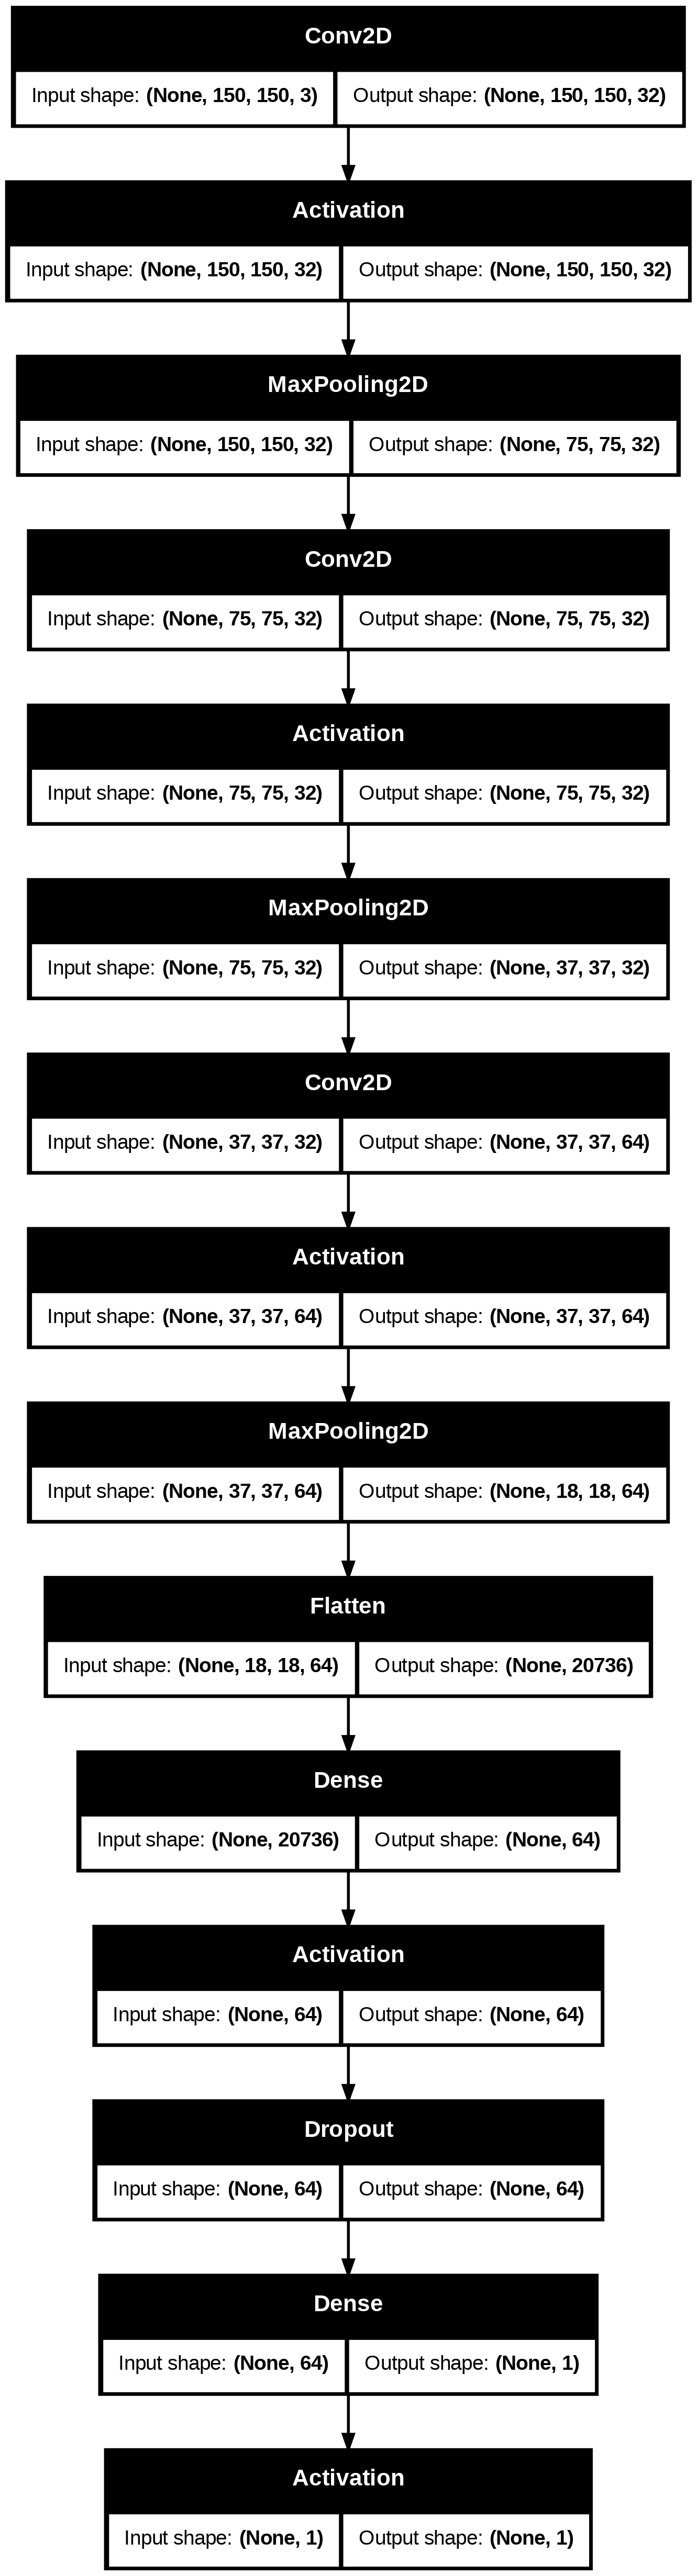

In [107]:
first_model = createFirstModel(input_shape=IMG_SHAPE)
plotFile = plotModel(first_model, "first_model")
IPython.display.Image( plotFile)


In [108]:
first_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 75, 75, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │     1,327,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,355,873 (5.17 MB)

 Trainable params: 1,355,873 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

In [109]:
first_history = trainModel(first_model, train_data_dir, validation_data_dir  )

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - acc: 0.5283 - loss: 0.7419

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - acc: 0.5283 - loss: 0.7416 - val_acc: 0.6237 - val_loss: 0.6717
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - acc: 0.5692 - loss: 0.6880 - val_acc: 0.6500 - val_loss: 0.6448
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - acc: 0.6265 - loss: 0.6567 - val_acc: 0.6488 - val_loss: 0.6370
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - acc: 0.6636 - loss: 0.6146 - val_acc: 0.6587 - val_loss: 0.6712
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - acc: 0.6732 - loss: 0.6239 - val_acc: 0.6513 - val_loss: 0.6462


In [110]:
first_model.save('transfer_learning_irst_try.keras')

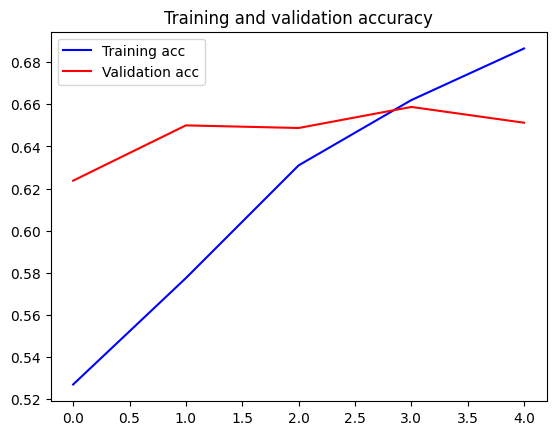

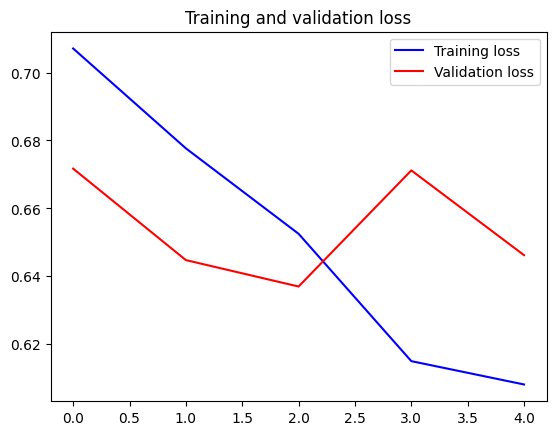

In [111]:
plot_training(first_history)

In [112]:
import numpy as np
from keras.preprocessing.image import load_img

def show_errors(model, data_generator, data_dir, start=0, end=None):
  """
  Show misclassified images

  Adapted from: https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

  data_generator generates images to classify
  - n.b., shuffle=False should be set when constructing this generator
  --- this is b/c when we ask the generator for .filenames and .classes  it is deterministic
  ---- the .classes form the "ground truth" against which predictions are evaluated so the order of examples must be deterministic
  Parameters
  -----------
  model: model for prediction
  data_generator: generator for data
  data_dir: the directory from which the generator obtains its data
  start, end: Integers.  Indices for first and last error (first error is 0)
  """

  # Get the filenames from the generator
  fnames = data_generator.filenames

  # Get the ground truth from generator
  ground_truth = data_generator.classes

  # Get the label to class mapping from the generator
  # i.e., { "class 0": 0, "class 1": 1, ... }
  label2index = xvalidation_generator.class_indices

  # Getting the mapping from class index to class label
  idx2label = dict((v,k) for k,v in label2index.items())

  # Get the predictions from the model using the generator
  predictions = model.predict(data_generator, steps=int(data_generator.samples/data_generator.batch_size),verbose=1)

  # Handle special case where prediction is binary, not categorical
  # convert it into 2 categories
  if predictions.shape[-1] == 1:
    predictions = np.c_[ 1-predictions, predictions]

  predicted_classes = np.argmax(predictions,axis=1)

  # errors: list of indices where prediction is wrong
  errors = np.where(predicted_classes != ground_truth)[0]
  print("No of errors = {}/{}".format(len(errors),data_generator.samples))

  if end is None:
    end = len(errors)

  # Show the errors
  for i in range(start, end):
      pred_class = np.argmax(predictions[errors[i]])
      pred_label = idx2label[pred_class]

      title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
          fnames[errors[i]].split('/')[0],
          pred_label,
          predictions[errors[i]][pred_class])

      original = load_img('{}/{}'.format(data_dir,fnames[errors[i]]))
      plt.figure(figsize=[7,7])
      plt.axis('off')
      plt.title(title)
      plt.imshow(original)
      plt.show()

Found 800 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
No of errors = 281/800


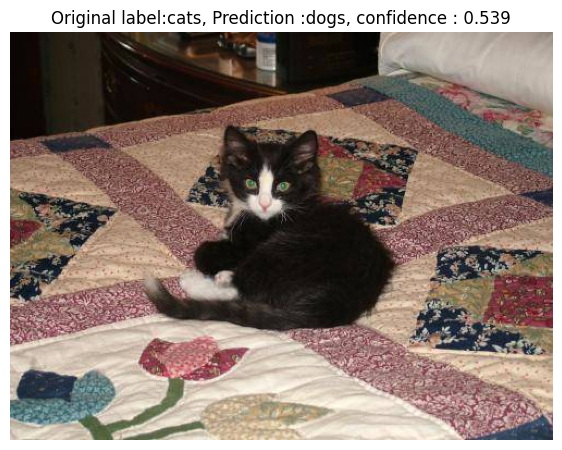

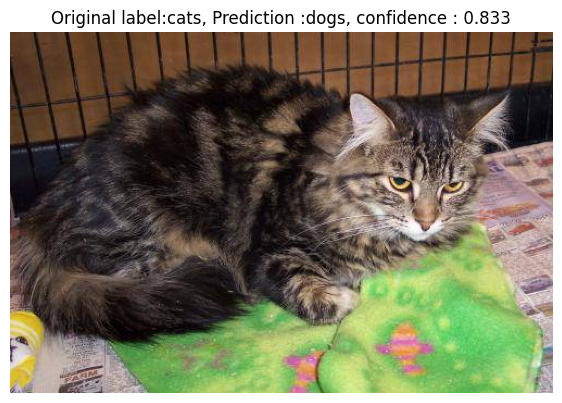

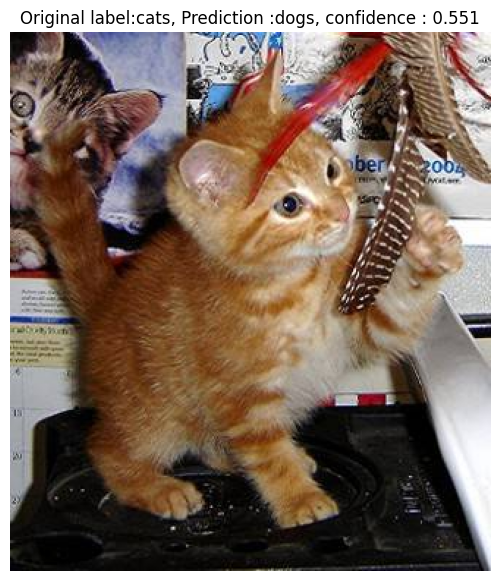

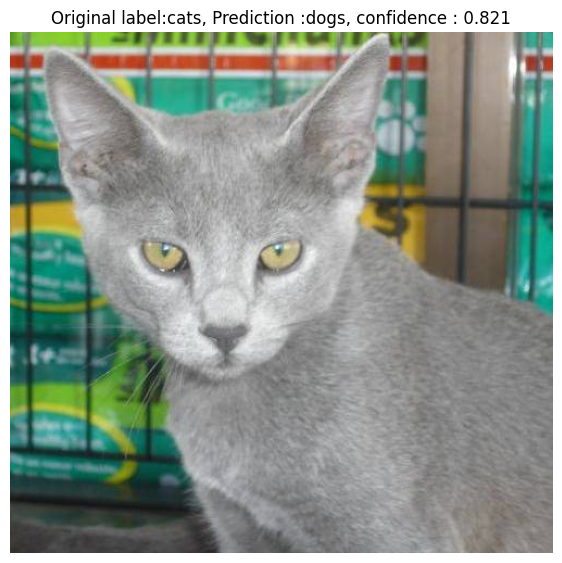

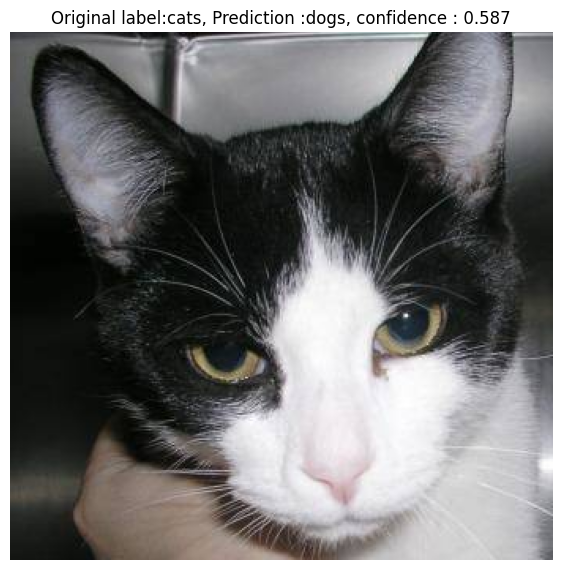

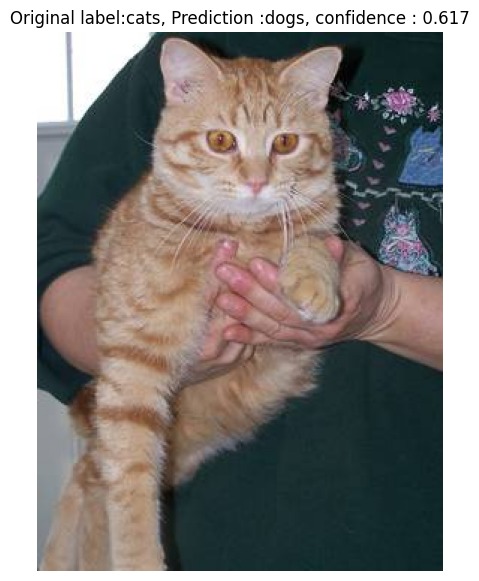

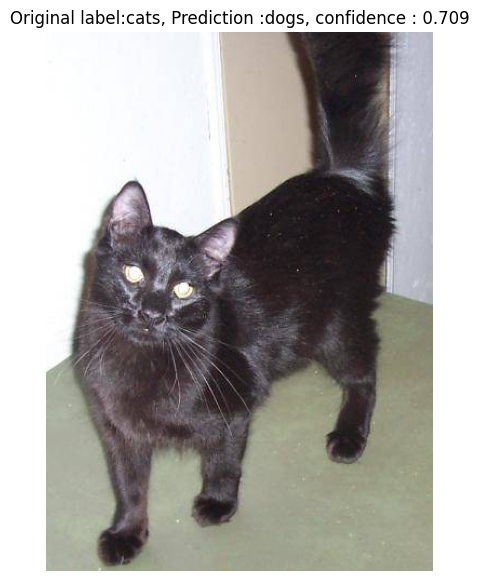

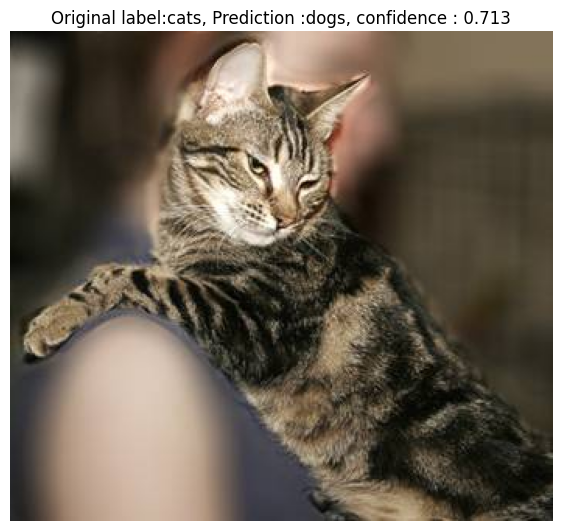

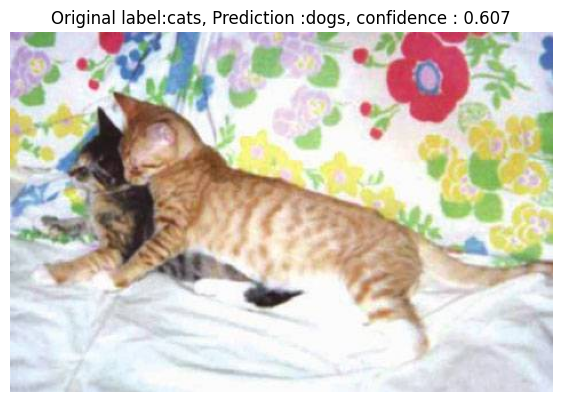

In [113]:
test_datagen = ImageDataGenerator(rescale=1. / 255)


# Need validation set to NOT be shuffled
#- n.b., shuffle=False should be set when constructing this generator
#  --- this is b/c when we ask the generator for .filenames and .classes  it is deterministic
#  ---- the .classes form the "ground truth" against which predictions are evaluated so the order of examples must be deterministic
xvalidation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='binary',
      shuffle=False)

show_errors(first_model, xvalidation_generator, validation_data_dir, start=1, end=10)

# Load a pre-trained VGG16 model

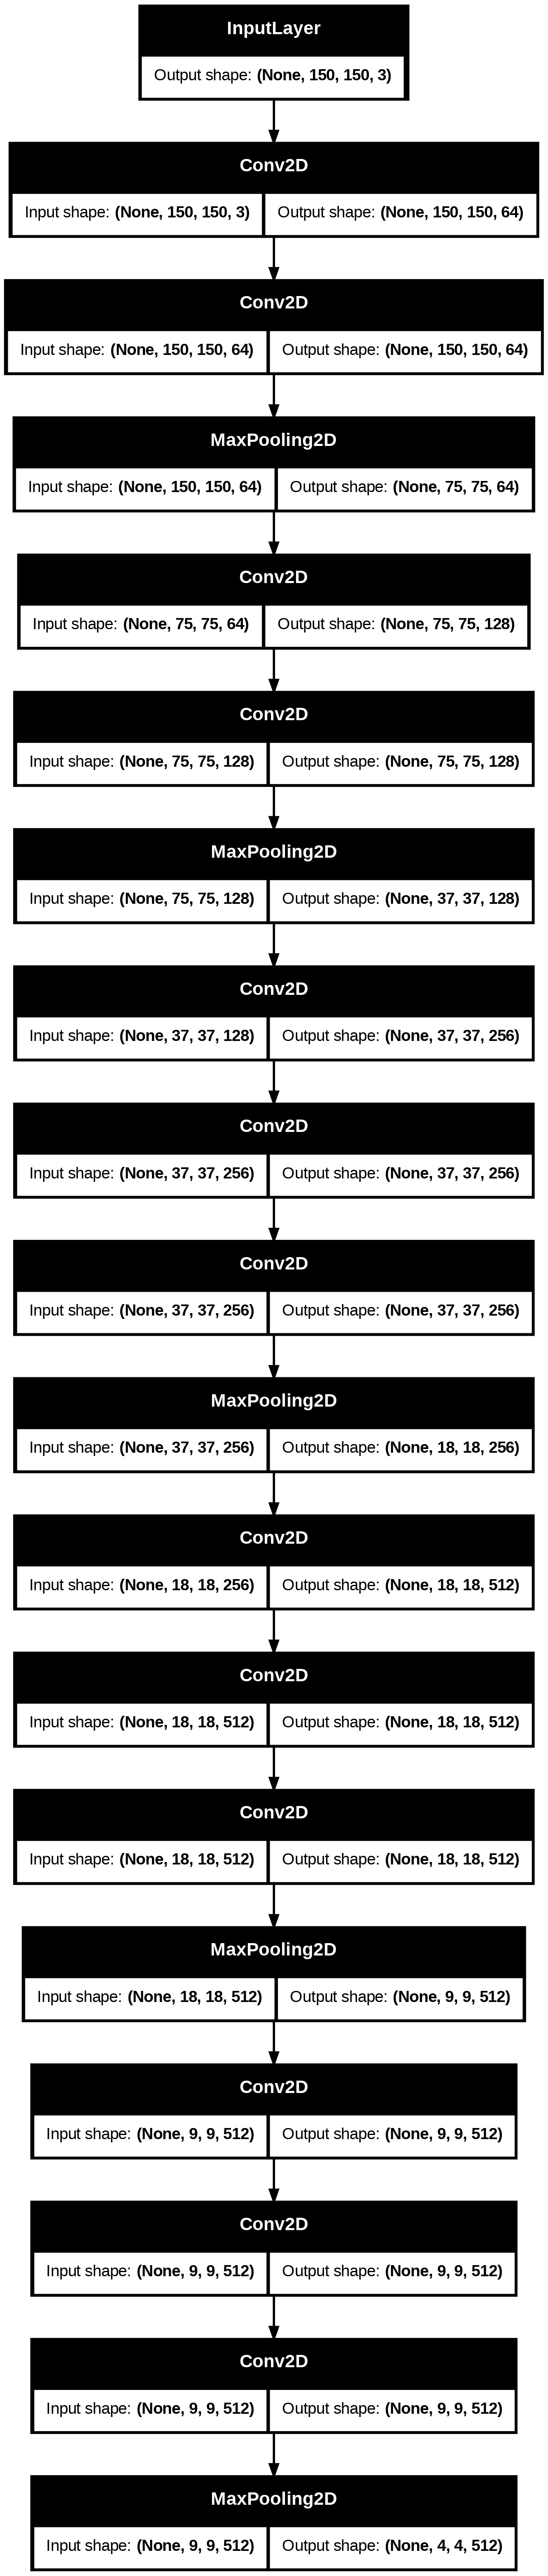

In [114]:
base_model = keras.applications.VGG16(input_shape=IMG_SHAPE,
                                     include_top=False,
                                     weights='imagenet')

plotFile = plotModel(base_model, "vgg16_model")
IPython.display.Image( plotFile)



In [115]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

# Transfer Learning: Graft a new head onto VGG 16

In [117]:
transf_model = createTransferModel(base_model, base_model.layers[-1].name)
transf_model.summary()

Last layer block5_pool is index 18


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 4, 4, 32)       │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,747,553 (56.26 MB)

 Trainable params: 32,865 (128.38 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - acc: 0.6092 - loss: 0.6688

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - acc: 0.6100 - loss: 0.6679 - val_acc: 0.8788 - val_loss: 0.3147
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 147ms/step - acc: 0.8397 - loss: 0.3733 - val_acc: 0.9025 - val_loss: 0.2608
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - acc: 0.8610 - loss: 0.3287 - val_acc: 0.8988 - val_loss: 0.2509
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - acc: 0.8871 - loss: 0.2579 - val_acc: 0.8900 - val_loss: 0.2514
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - acc: 0.8768 - loss: 0.2666 - val_acc: 0.9038 - val_loss: 0.2513


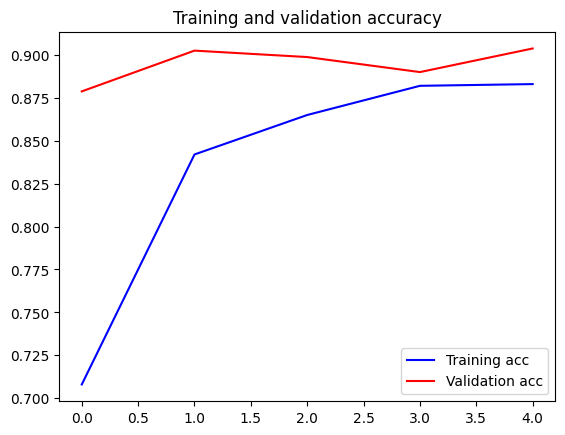

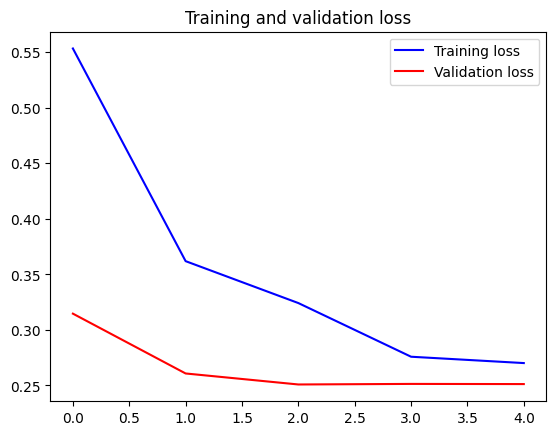

In [118]:
transf_history = trainModel(transf_model, train_data_dir, validation_data_dir)
plot_training(transf_history)

# Transfer Learning: Graft a new suffix onto a VGG16 prefix
- Do we do better or worse by elminating later layers of VGG 16 (perhaps too specialized ?)

In [119]:
transf_model = createTransferModel(base_model, 'block4_pool')

Last layer block4_pool is index 14


In [120]:
transf_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 9, 9, 32)       │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 2592)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │        82,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,734,689 (29.51 MB)

 Trainable params: 99,425 (388.38 KB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [121]:
transf_history = trainModel(transf_model, train_data_dir, validation_data_dir)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - acc: 0.5880 - loss: 0.9008

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - acc: 0.5884 - loss: 0.8992 - val_acc: 0.8512 - val_loss: 0.4093
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 139ms/step - acc: 0.8149 - loss: 0.4162 - val_acc: 0.8875 - val_loss: 0.2698
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - acc: 0.8612 - loss: 0.3190 - val_acc: 0.9013 - val_loss: 0.2424
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - acc: 0.8974 - loss: 0.2789 - val_acc: 0.8950 - val_loss: 0.2571
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - acc: 0.9067 - loss: 0.2603 - val_acc: 0.9050 - val_loss: 0.2403


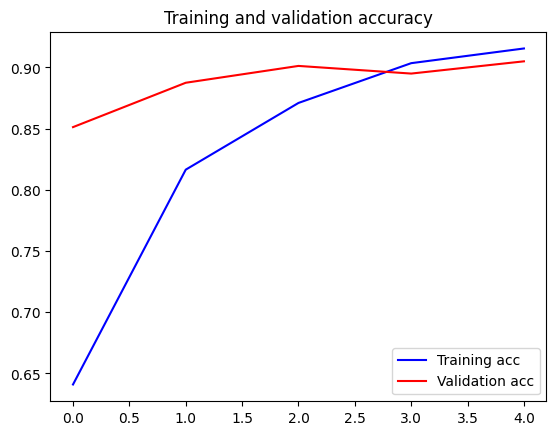

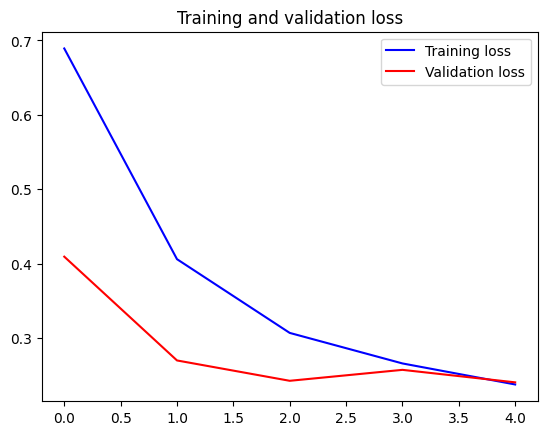

In [122]:
plot_training(transf_history)

# Transfer Learning: Graft a new head onto *an even shorter* prefix of VGG 16.
- Can we still learn ?

In [123]:
transf_model = createTransferModel(base_model, 'block3_pool')
transf_model.summary()

Last layer block3_pool is index 10


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 18, 18, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │       331,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,075,553 (7.92 MB)

 Trainable params: 340,065 (1.30 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - acc: 0.5211 - loss: 4.9263

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - acc: 0.5213 - loss: 4.9015 - val_acc: 0.7688 - val_loss: 0.6664
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - acc: 0.6121 - loss: 0.6688 - val_acc: 0.7163 - val_loss: 0.5933
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - acc: 0.6332 - loss: 0.6303 - val_acc: 0.6725 - val_loss: 0.8308
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - acc: 0.6612 - loss: 0.6443 - val_acc: 0.8112 - val_loss: 0.5402
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - acc: 0.7001 - loss: 0.6233 - val_acc: 0.8288 - val_loss: 0.4231
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - acc: 0.7264 - loss: 0.5812 - val_acc: 0.8250 - val_loss: 0.4107
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - acc: 0.7306 - loss: 0.5911 - val_acc: 0.8450 - val_loss: 0.4013
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - acc: 0.7714 - loss: 0.5234 - val_acc: 0.8125 - val_loss: 0.4320
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s

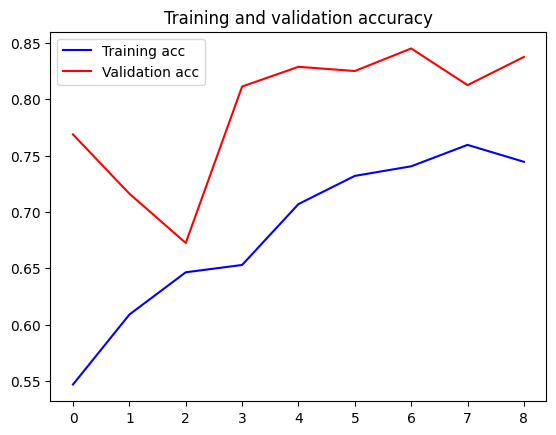

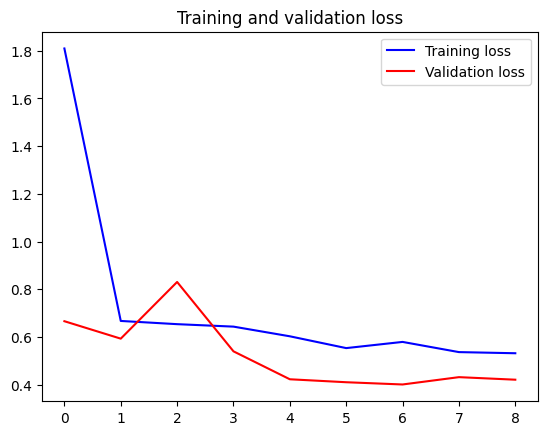

In [124]:
transf_history = trainModel(transf_model, train_data_dir, validation_data_dir)
plot_training(transf_history)